# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups               
Sample_159  D6RER2;D6RIH8;Q13634;Q13634-2   17.963
Sample_107  P26038                          16.341
Sample_096  P05413;S4R371                   15.666
Sample_019  P25189;P25189-2                 13.755
Sample_055  Q15375;Q15375-4                 15.625
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups
Sample_053  P00491           13.612
Sample_041  Q6UWR7           14.741
Sample_008  P30043           14.557
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.903
            A0A075B6Q5                 12.233
            A0A075B6R2                 14.064
            A0A075B6S5                 13.802
            A0A087WSY4                 13.065
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.479
            Q9UI40;Q9UI40-2            11.770
            Q9UIW2                     11.322
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.979
            Q9UP79                     13.260
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.233,15.050,16.842,19.863,16.032,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.600,19.067,...,15.528,15.576,14.266,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.888,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.351,17.705,17.039,15.852,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.480,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.819,15.345,17.084,18.708,14.249,19.433,11.567,10.561
Sample_207,15.739,16.877,15.469,16.898,13.279,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.302,11.790,11.439,12.860,12.623,13.817,11.755,12.796,12.225,13.540
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.367,19.067,16.127,...,11.494,13.737,13.857,11.847,12.505,12.136,12.209,13.108,13.116,12.348
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.266,13.292,12.578,12.467,13.010,13.474,12.896,13.423,11.865,10.860
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.284,11.891,12.476,12.791,13.765,13.953,12.428,12.836,12.174,13.997
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.694,12.868,12.831,12.525,13.517,12.814,13.247,12.789,13.445,13.386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.841,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 407.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

100%|██████████| 2/2 [00:00<00:00,  7.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.21it/s]

100%|██████████| 3/3 [00:00<00:00,  5.28it/s]

100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.59it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.10it/s]

100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.31it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.25it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.74it/s]

100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.94it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.74it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.00it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.42it/s]

100%|██████████| 6/6 [00:01<00:00,  4.05it/s]

100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.81it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.68it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.41it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.33it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.06it/s]

100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.13it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.58it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.24it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.82it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.90it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.88it/s]

100%|██████████| 8/8 [00:01<00:00,  3.71it/s]

100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.95it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.35it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.57it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.27it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.08it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.01it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.63it/s]

100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.96it/s]

 30%|███       | 3/10 [00:00<00:01,  5.77it/s]

 40%|████      | 4/10 [00:00<00:01,  4.85it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.20it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.22it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.15it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.94it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.04it/s]

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.29it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.06it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.77it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.38it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.36it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.80it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.71it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.50it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.65it/s]

100%|██████████| 11/11 [00:02<00:00,  3.65it/s]

100%|██████████| 11/11 [00:02<00:00,  4.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.48it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.27it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.50it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.34it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.28it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.28it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.19it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.23it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.15it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.09it/s]

100%|██████████| 12/12 [00:02<00:00,  4.11it/s]

100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.92it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.12it/s]

 31%|███       | 4/13 [00:01<00:02,  3.19it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.02it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.89it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.92it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.88it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.76it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.79it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.81it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.70it/s]

100%|██████████| 13/13 [00:04<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.92it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.90it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.28it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.06it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.14it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.27it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.39it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.40it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.40it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.40it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.51it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.42it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.56it/s]

100%|██████████| 14/14 [00:04<00:00,  3.72it/s]

100%|██████████| 14/14 [00:04<00:00,  3.48it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.96it/s]

 20%|██        | 3/15 [00:00<00:02,  5.15it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.38it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.12it/s]

 40%|████      | 6/15 [00:01<00:02,  3.26it/s]

 47%|████▋     | 7/15 [00:01<00:02,  2.95it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.77it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.77it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.70it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.73it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.87it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.73it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.94it/s]

100%|██████████| 15/15 [00:04<00:00,  3.32it/s]

100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.033 0.003          0.801 0.316       0.122   
2             0.003 0.000      0.037 0.010          0.651 0.173       0.306   
3             0.003 0.000      0.036 0.000          0.740 0.105       0.675   
4             0.003 0.000      0.036 0.001          0.705 0.092       0.689   
5             0.003 0.000      0.036 0.001          0.794 0.105       0.709   
6             0.003 0.001      0.037 0.009          0.808 0.086       0.775   
7             0.004 0.000      0.037 0.003          0.829 0.077       0.782   
8             0.004 0.000      0.038 0.006          0.833 0.079       0.783   
9             0.004 0.000      0.036 0.001          0.825 0.086       0.830   
10            0.004 0.002      0.038 0.006          0.834 0.084       0.828   
11            0.004 0.000      0.036 0.002          0.837 0.077       0.833   
12            0.004 0.000      0.036 0.004          0.839 0.072       0.832   
13            0.004 0.002      0.042 0.013          0.832 0.076       0.829   
14            0.005 0.003      0.049 0.019          0.834 0.076       0.824   
15            0.004 0.003      0.040 0.011          0.826 0.084       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.204 0.122                  0.554 0.039        0.856   
2          0.101   0.402 0.100                  0.584 0.052        0.724   
3          0.113   0.701 0.091                  0.749 0.072        0.829   
4          0.116   0.691 0.086                  0.738 0.069        0.831   
5          0.122   0.741 0.089                  0.783 0.069        0.883   
6          0.105   0.787 0.076                  0.819 0.064        0.913   
7          0.099   0.801 0.071                  0.831 0.058        0.917   
8          0.092   0.803 0.068                  0.833 0.056        0.916   
9          0.094   0.824 0.073                  0.849 0.064        0.925   
10         0.092   0.827 0.070                  0.852 0.060        0.925   
11         0.092   0.831 0.065                  0.856 0.055        0.924   
12         0.095   0.832 0.065                  0.857 0.055        0.924   
13         0.102   0.826 0.069                  0.852 0.059        0.922   
14         0.101   0.825 0.070                  0.851 0.060        0.921   
15         0.086   0.816 0.068                  0.842 0.058        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.823 0.088        210.000 0.000  
2          0.083                  0.646 0.106        210.000 0.000  
3          0.065                  0.785 0.094        210.000 0.000  
4          0.061                  0.775 0.090        210.000 0.000  
5          0.055                  0.837 0.077        210.000 0.000  
6          0.044                  0.884 0.059        210.000 0.000  
7          0.046                  0.888 0.063        210.000 0.000  
8          0.048                  0.887 0.065        210.000 0.000  
9          0.043                  0.906 0.051        210.000 0.000  
10         0.044                  0.905 0.054        210.000 0.000  
11         0.043                  0.901 0.056        210.000 0.000  
12         0.043                  0.902 0.056        210.000 0.000  
13         0.043                  0.899 0.056        210.000 0.000  
14         0.045                  0.898 0.058        210.000 0.000  
15         0.043                  0.906 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 455.06it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.63it/s]

100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.85it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.64it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.68it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.25it/s]

100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.73it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.19it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.37it/s]

100%|██████████| 6/6 [00:01<00:00,  3.58it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.43it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.95it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.12it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.81it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.62it/s]

100%|██████████| 7/7 [00:01<00:00,  3.41it/s]

100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.13it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.18it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.10it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.69it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.27it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.35it/s]

100%|██████████| 8/8 [00:02<00:00,  3.40it/s]

100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.36it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.27it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.94it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.96it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.57it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.26it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.44it/s]

100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.03it/s]

 30%|███       | 3/10 [00:00<00:01,  3.64it/s]

 40%|████      | 4/10 [00:01<00:01,  3.02it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.93it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.88it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.97it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.07it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.07it/s]

100%|██████████| 10/10 [00:03<00:00,  3.15it/s]

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.60it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.50it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.28it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.40it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.30it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.14it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.08it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.06it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.09it/s]

100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

100%|██████████| 11/11 [00:03<00:00,  3.26it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.51it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.03it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.13it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.89it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.90it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.91it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.92it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.02it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.11it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.18it/s]

100%|██████████| 12/12 [00:03<00:00,  3.16it/s]

100%|██████████| 12/12 [00:03<00:00,  3.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.10it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.25it/s]

 31%|███       | 4/13 [00:00<00:02,  3.74it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.47it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.25it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.55it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.46it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.25it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.19it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.24it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.33it/s]

100%|██████████| 13/13 [00:04<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.70it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.45it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.45it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.78it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.65it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.52it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.36it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.32it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.29it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.23it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.21it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.82it/s]

100%|██████████| 14/14 [00:04<00:00,  2.53it/s]

100%|██████████| 14/14 [00:04<00:00,  3.25it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.48it/s]

 20%|██        | 3/15 [00:00<00:03,  3.57it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.13it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.80it/s]

 40%|████      | 6/15 [00:02<00:03,  2.60it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.30it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.33it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.38it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.50it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.36it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.56it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.72it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.73it/s]

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]

100%|██████████| 15/15 [00:05<00:00,  2.74it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.039 0.012          0.158 0.330       0.020   
2             0.003 0.000      0.039 0.010          0.750 0.126       0.638   
3             0.004 0.002      0.045 0.015          0.782 0.090       0.712   
4             0.005 0.004      0.057 0.023          0.783 0.095       0.716   
5             0.004 0.003      0.055 0.023          0.773 0.095       0.712   
6             0.005 0.004      0.054 0.021          0.786 0.096       0.708   
7             0.004 0.003      0.047 0.017          0.781 0.097       0.703   
8             0.005 0.003      0.049 0.020          0.783 0.094       0.780   
9             0.004 0.003      0.046 0.017          0.784 0.095       0.778   
10            0.005 0.003      0.051 0.019          0.769 0.086       0.770   
11            0.005 0.004      0.048 0.017          0.789 0.084       0.790   
12            0.004 0.002      0.044 0.016          0.804 0.085       0.794   
13            0.005 0.004      0.043 0.018          0.803 0.077       0.805   
14            0.005 0.003      0.050 0.019          0.839 0.087       0.798   
15            0.005 0.003      0.041 0.012          0.851 0.089       0.813   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.048   0.034 0.079                  0.505 0.021        0.867   
2          0.124   0.679 0.092                  0.735 0.073        0.799   
3          0.112   0.738 0.069                  0.780 0.053        0.861   
4          0.115   0.741 0.077                  0.783 0.059        0.862   
5          0.101   0.734 0.066                  0.776 0.051        0.865   
6          0.113   0.737 0.073                  0.780 0.056        0.866   
7          0.108   0.733 0.073                  0.777 0.056        0.864   
8          0.116   0.775 0.077                  0.808 0.064        0.898   
9          0.112   0.775 0.076                  0.808 0.063        0.897   
10         0.115   0.763 0.076                  0.799 0.064        0.900   
11         0.124   0.784 0.084                  0.817 0.070        0.910   
12         0.117   0.793 0.080                  0.825 0.066        0.912   
13         0.118   0.799 0.075                  0.829 0.062        0.916   
14         0.099   0.814 0.071                  0.841 0.059        0.929   
15         0.107   0.826 0.077                  0.853 0.064        0.929   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.834 0.086        210.000 0.000  
2          0.073                  0.739 0.094        210.000 0.000  
3          0.055                  0.831 0.075        210.000 0.000  
4          0.055                  0.831 0.079        210.000 0.000  
5          0.055                  0.828 0.076        210.000 0.000  
6          0.057                  0.827 0.078        210.000 0.000  
7          0.056                  0.829 0.074        210.000 0.000  
8          0.051                  0.878 0.058        210.000 0.000  
9          0.051                  0.876 0.059        210.000 0.000  
10         0.049                  0.880 0.055        210.000 0.000  
11         0.049                  0.893 0.053        210.000 0.000  
12         0.049                  0.897 0.053        210.000 0.000  
13         0.046                  0.902 0.051        210.000 0.000  
14         0.040                  0.916 0.045        210.000 0.000  
15         0.041                  0.916 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1005.59it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.69it/s]

100%|██████████| 3/3 [00:00<00:00, 18.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.87it/s]

100%|██████████| 4/4 [00:00<00:00, 19.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.06it/s]

100%|██████████| 5/5 [00:00<00:00, 15.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 24.59it/s]

100%|██████████| 6/6 [00:00<00:00, 19.99it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.52it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 16.25it/s]

100%|██████████| 7/7 [00:00<00:00, 13.83it/s]

100%|██████████| 7/7 [00:00<00:00, 14.69it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.73it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.62it/s]

100%|██████████| 8/8 [00:00<00:00, 15.46it/s]

100%|██████████| 8/8 [00:00<00:00, 15.87it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.05it/s]

 44%|████▍     | 4/9 [00:00<00:00, 15.97it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.95it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.47it/s]

100%|██████████| 9/9 [00:00<00:00, 13.58it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.73it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.75it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.48it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.96it/s]

100%|██████████| 10/10 [00:00<00:00, 12.83it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.17it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.65it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.20it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.97it/s]

100%|██████████| 11/11 [00:00<00:00, 11.06it/s]

100%|██████████| 11/11 [00:00<00:00, 11.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.01it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.38it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.38it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.10it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.00it/s]

100%|██████████| 12/12 [00:00<00:00, 12.93it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.70it/s]

 31%|███       | 4/13 [00:00<00:00, 14.76it/s]

 46%|████▌     | 6/13 [00:00<00:00, 13.07it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.73it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.92it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.20it/s]

100%|██████████| 13/13 [00:00<00:00, 13.75it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.81it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.10it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.10it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.36it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.03it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.20it/s]

100%|██████████| 14/14 [00:01<00:00, 11.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.90it/s]

 27%|██▋       | 4/15 [00:00<00:00, 12.01it/s]

 40%|████      | 6/15 [00:00<00:00, 11.15it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.88it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.33it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.55it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.78it/s]

100%|██████████| 15/15 [00:01<00:00, 12.87it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.016          0.000 0.000       0.000   
2             0.005 0.005      0.055 0.021          0.237 0.391       0.022   
3             0.004 0.003      0.039 0.008          0.329 0.432       0.032   
4             0.004 0.001      0.048 0.018          0.664 0.110       0.573   
5             0.004 0.004      0.039 0.010          0.665 0.102       0.570   
6             0.005 0.007      0.051 0.020          0.672 0.092       0.674   
7             0.004 0.002      0.038 0.009          0.677 0.083       0.659   
8             0.008 0.007      0.090 0.029          0.664 0.081       0.641   
9             0.005 0.004      0.050 0.021          0.663 0.076       0.652   
10            0.007 0.007      0.057 0.028          0.655 0.075       0.644   
11            0.005 0.004      0.041 0.014          0.698 0.080       0.681   
12            0.006 0.006      0.059 0.024          0.690 0.079       0.684   
13            0.005 0.003      0.052 0.020          0.689 0.078       0.682   
14            0.006 0.006      0.063 0.031          0.691 0.076       0.683   
15            0.004 0.002      0.039 0.015          0.684 0.074       0.673   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.756   
2          0.036   0.038 0.060                  0.503 0.019        0.600   
3          0.040   0.056 0.069                  0.502 0.032        0.555   
4          0.118   0.608 0.091                  0.678 0.070        0.749   
5          0.110   0.607 0.080                  0.678 0.060        0.751   
6          0.122   0.668 0.088                  0.716 0.072        0.806   
7          0.123   0.662 0.086                  0.714 0.067        0.808   
8          0.127   0.647 0.090                  0.702 0.067        0.801   
9          0.119   0.652 0.081                  0.704 0.064        0.799   
10         0.117   0.644 0.081                  0.698 0.065        0.797   
11         0.111   0.685 0.080                  0.732 0.065        0.825   
12         0.110   0.682 0.075                  0.728 0.060        0.821   
13         0.104   0.681 0.076                  0.728 0.061        0.819   
14         0.113   0.682 0.078                  0.729 0.061        0.818   
15         0.113   0.673 0.075                  0.722 0.059        0.815   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.700 0.086        210.000 0.000  
2          0.108                  0.543 0.106        210.000 0.000  
3          0.106                  0.509 0.095        210.000 0.000  
4          0.070                  0.684 0.085        210.000 0.000  
5          0.066                  0.689 0.082        210.000 0.000  
6          0.069                  0.751 0.082        210.000 0.000  
7          0.069                  0.751 0.084        210.000 0.000  
8          0.069                  0.742 0.084        210.000 0.000  
9          0.067                  0.746 0.080        210.000 0.000  
10         0.067                  0.744 0.079        210.000 0.000  
11         0.061                  0.778 0.074        210.000 0.000  
12         0.060                  0.772 0.075        210.000 0.000  
13         0.064                  0.771 0.078        210.000 0.000  
14         0.064                  0.770 0.079        210.000 0.000  
15         0.064                  0.764 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,4,8
score_time,14,4,8
test_precision,12,15,11
test_recall,11,15,12
test_f1,12,15,11
test_balanced_accuracy,12,15,11
test_roc_auc,15,14,11
test_average_precision,15,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.35it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.84it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.33it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.21it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.16it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.89it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.73it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.66it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.64it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.76it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.48it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.25it/s]

100%|██████████| 14/14 [00:05<00:00,  2.25it/s]

100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.91it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.70it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.52it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.52it/s]

100%|██████████| 11/11 [00:00<00:00, 11.76it/s]

100%|██████████| 11/11 [00:00<00:00, 12.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.79it/s]

 20%|██        | 3/15 [00:00<00:03,  3.22it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.82it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.90it/s]

 40%|████      | 6/15 [00:01<00:03,  2.93it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.86it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.88it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.94it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.02it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.19it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.87it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.03it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.17it/s]

100%|██████████| 15/15 [00:04<00:00,  2.97it/s]

100%|██████████| 15/15 [00:04<00:00,  3.02it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


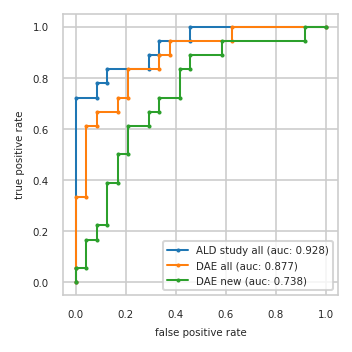

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.722   0.000 0.333   0.042 0.056
3          0.083 0.722   0.042 0.333   0.042 0.167
4          0.083 0.778   0.042 0.611   0.083 0.167
5          0.125 0.778   0.083 0.611   0.083 0.222
6          0.125 0.833   0.083 0.667   0.125 0.222
7          0.292 0.833   0.167 0.667   0.125 0.389
8          0.292 0.889   0.167 0.722   0.167 0.389
9          0.333 0.889   0.208 0.722   0.167 0.500
10         0.333 0.944   0.208 0.833   0.208 0.500
11         0.458 0.944   0.333 0.833   0.208 0.611
12         0.458 1.000   0.333 0.889   0.292 0.611
13         1.000 1.000   0.375 0.889   0.292 0.667
14           NaN   NaN   0.375 0.944   0.333 0.667
15           NaN   NaN   0.625 0.944   0.333 0.722
16           NaN   NaN   0.625 1.000   0.417 0.722
17           NaN   NaN   1.000 1.000   0.417 0.833
18           NaN   NaN     NaN   NaN   0.458 0.833
19           NaN   NaN     NaN   NaN   0.458 0.889
20           NaN   NaN     NaN   NaN   0.583 0.889
21           NaN   NaN     NaN   NaN   0.583 0.944
22           NaN   NaN     NaN   NaN   0.917 0.944
23           NaN   NaN     NaN   NaN   0.917 1.000
24           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q15848,P09960;P09960-4,P51688
2,P09960;P09960-4,Q8NFY4;Q8NFY4-6,A0A087WXB8;Q9Y274
3,P61981,P02741,P31321
4,P14174,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P04075,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,P00338;P00338-3,P04075,P51674;P51674-2;P51674-3
7,Q9Y2T3;Q9Y2T3-3,P14174,J3KSJ8;Q9UD71;Q9UD71-2
8,P08294,Q14894,P10644;P10644-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


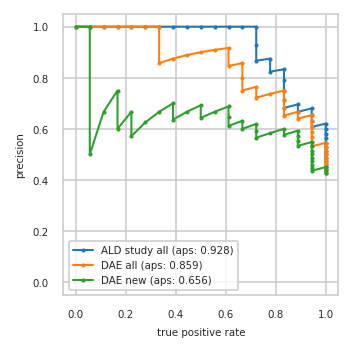

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.548 0.944
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.593 0.889
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.680 0.944     0.640 0.889     0.600 0.833
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.750 0.833     0.750 0.833     0.600 0.667
23         0.789 0.833     0.737 0.778     0.632 0.667
24         0.833 0.833     0.722 0.722     0.611 0.611
25         0.824 0.778     0.765 0.722     0.647 0.611
26         0.875 0.778     0.750 0.667     0.688 0.611
27         0.867 0.722     0.800 0.667     0.667 0.556
28         0.929 0.722     0.857 0.667     0.643 0.500
29         1.000 0.722     0.846 0.611     0.692 0.500
30         1.000 0.667     0.917 0.611     0.667 0.444
31         1.000 0.611     0.909 0.556     0.636 0.389
32         1.000 0.556     0.900 0.500     0.700 0.389
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


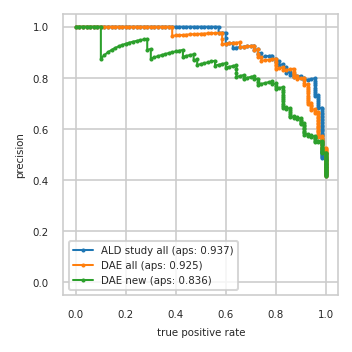

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


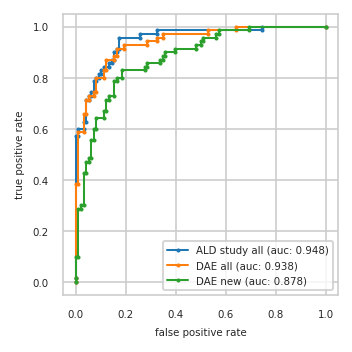

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}